In [1]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

Files already downloaded and verified
Files already downloaded and verified


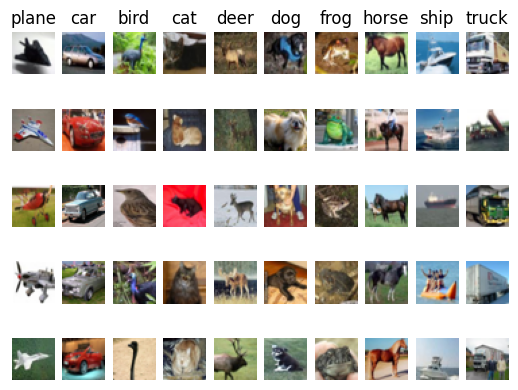

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(10):
    idx = np.where(np.array(trainset.targets) == i)[0]
    for j in range(5):
        plt.subplot(5, 10, j * 10 + i + 1)
        plt.imshow(trainset.data[idx[j]])
        plt.axis('off')
        if j == 0:
            plt.title(classes[i])
plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainset.targets = np.array(trainset.targets)
testset.targets = np.array(testset.targets)
idx = np.where((trainset.targets == 0) | (trainset.targets == 1))[0]
trainset.data = trainset.data[idx]
trainset.targets = trainset.targets[idx]
idx = np.where((testset.targets == 0) | (testset.targets == 1))[0]
testset.data = testset.data[idx]
testset.targets = testset.targets[idx]

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [3]:
net = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
net.fc = nn.Linear(2048, 2)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Epoch 0 | Loss: 0.4737 | Acc: 0.8573: 100%|██████████| 157/157 [00:12<00:00, 12.66it/s]
Epoch 1 | Loss: 0.3654 | Acc: 0.9508: 100%|██████████| 157/157 [00:11<00:00, 13.71it/s]
Epoch 2 | Loss: 0.3440 | Acc: 0.9725: 100%|██████████| 157/157 [00:10<00:00, 15.08it/s]
Epoch 3 | Loss: 0.3354 | Acc: 0.9808: 100%|██████████| 157/157 [00:10<00:00, 14.51it/s]
Epoch 4 | Loss: 0.3267 | Acc: 0.9891: 100%|██████████| 157/157 [00:10<00:00, 14.72it/s]
Epoch 5 | Loss: 0.3255 | Acc: 0.9898: 100%|██████████| 157/157 [00:11<00:00, 14.09it/s]
Epoch 6 | Loss: 0.3220 | Acc: 0.9931: 100%|██████████| 157/157 [00:11<00:00, 13.45it/s]
Epoch 7 | Loss: 0.3214 | Acc: 0.9932: 100%|██████████| 157/157 [00:12<00:00, 13.07it/s]
Epoch 8 | Loss: 0.3188 | Acc: 0.9953: 100%|██████████| 157/157 [00:11<00:00, 13.15it/s]
Epoch 9 | Loss: 0.3192 | Acc: 0.9950: 100%|██████████| 157/157 [00:11<00:00, 13.17it/s]


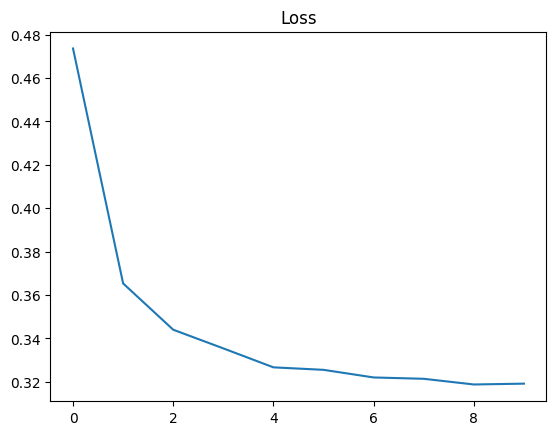

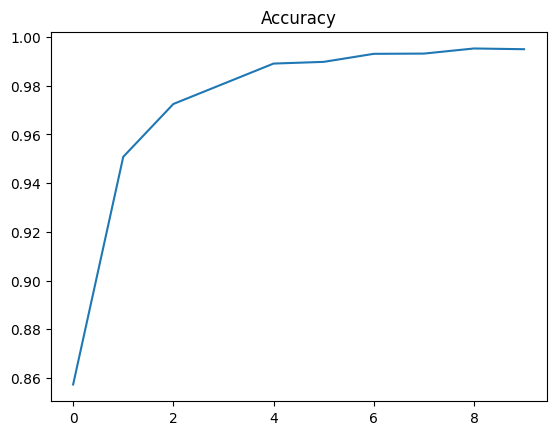

In [4]:
def train(epoch, net, optimizer, criterion):
    y_true = []
    y_pred = []
    loss_list = []
    net.train()
    pbar = tqdm(trainloader)
    for batch_idx, (inputs, targets) in enumerate(pbar):
        y_true += targets.tolist()
        inputs, targets = inputs.to(device), targets.long().to(device)
        optimizer.zero_grad()
        outputs = F.softmax(net(inputs), dim=1)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted.tolist()
        loss = criterion(outputs, targets)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Epoch {epoch} | Loss: {np.mean(loss_list):.4f} | Acc: {accuracy_score(y_true, y_pred):.4f}')
    return np.mean(loss_list), accuracy_score(y_true, y_pred)
    
epochs = 10
loss_list = []
acc_list = []
for epoch in range(epochs):
    loss, acc = train(epoch, net, optimizer, criterion)
    loss_list.append(loss)
    acc_list.append(acc)

plt.plot(loss_list)
plt.title('Loss')
plt.show()
plt.plot(acc_list)
plt.title('Accuracy')
plt.show()

In [5]:
def test(net):
    y_true = []
    y_pred = []
    net.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            y_true += targets.tolist()
            inputs, targets = inputs.to(device), targets.long().to(device)
            outputs = F.softmax(net(inputs), dim=1)
            _, predicted = torch.max(outputs.data, 1)
            y_pred += predicted.tolist()
    return accuracy_score(y_true, y_pred)

print(f'Test accuracy: {test(net):.4f}')

Test accuracy: 0.9620


In [6]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        d_ap = F.pairwise_distance(anchor, positive)
        d_an = F.pairwise_distance(anchor, negative)
        loss = torch.mean(torch.clamp(d_ap - d_an + self.margin, min=0.0))
        return loss
    
class TripletDataset(CIFAR10):
    def __init__(self, root, train=True, transform=None, download=False):
        super().__init__(root, train=train, transform=transform, download=download)
        self.targets = np.array(self.targets)
        idx = np.where((self.targets == 0) | (self.targets == 1))[0]
        self.data = self.data[idx]
        self.targets = self.targets[idx]
        self.class_idx = {}
        self.class_idx[0] = np.where(self.targets == 0)[0]
        self.class_idx[1] = np.where(self.targets == 1)[0]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        anchor_img = img
        positive_idx = np.random.choice(self.class_idx[target])
        positive_img = self.data[positive_idx]
        negative_idx = np.random.choice(self.class_idx[1 - target])
        negative_img = self.data[negative_idx]
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        return anchor_img, positive_img, negative_img
    
    def __len__(self):
        return len(self.targets)

In [7]:
feature_extractor = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)
triplet_dataset = TripletDataset(root='./data', train=True, transform=transform, download=True)
triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)
triplet_criterion = TripletLoss()
triplet_optimizer = torch.optim.SGD(feature_extractor.parameters(), lr=0.001, momentum=0.9)

Files already downloaded and verified


Epoch 0 | Loss: 0.9788: 100%|██████████| 313/313 [00:34<00:00,  9.10it/s]
Epoch 1 | Loss: 0.4621: 100%|██████████| 313/313 [00:34<00:00,  9.11it/s]
Epoch 2 | Loss: 0.2142: 100%|██████████| 313/313 [00:34<00:00,  9.00it/s]
Epoch 3 | Loss: 0.1576: 100%|██████████| 313/313 [00:32<00:00,  9.54it/s]
Epoch 4 | Loss: 0.1001: 100%|██████████| 313/313 [00:39<00:00,  7.85it/s]
Epoch 5 | Loss: 0.0606: 100%|██████████| 313/313 [00:34<00:00,  9.09it/s]
Epoch 6 | Loss: 0.0391: 100%|██████████| 313/313 [00:29<00:00, 10.46it/s]
Epoch 7 | Loss: 0.0290: 100%|██████████| 313/313 [00:31<00:00,  9.92it/s]
Epoch 8 | Loss: 0.0179: 100%|██████████| 313/313 [00:33<00:00,  9.32it/s]
Epoch 9 | Loss: 0.0141: 100%|██████████| 313/313 [00:36<00:00,  8.62it/s]


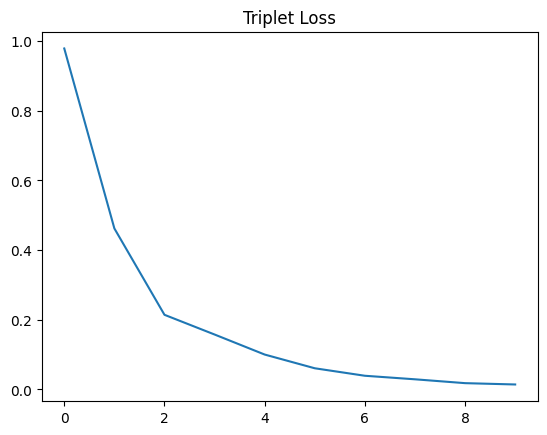

In [8]:
def train_triplet(epoch):
    loss_list = []
    feature_extractor.train()
    pbar = tqdm(triplet_loader)
    for batch_idx, (anchor, positive, negative) in enumerate(pbar):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        triplet_optimizer.zero_grad()
        anchor_output = feature_extractor(anchor)
        positive_output = feature_extractor(positive)
        negative_output = feature_extractor(negative)
        loss = triplet_criterion(anchor_output, positive_output, negative_output)
        loss_list.append(loss.item())
        loss.backward()
        triplet_optimizer.step()
        pbar.set_description(f'Epoch {epoch} | Loss: {np.mean(loss_list):.4f}')
    return np.mean(loss_list)

epochs = 10
loss_list = []
for epoch in range(epochs):
    loss = train_triplet(epoch)
    loss_list.append(loss)

plt.plot(loss_list)
plt.title('Triplet Loss')
plt.show()

In [9]:
feature_extractor.fc = nn.Linear(2048, 2)
feature_extractor = feature_extractor.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(feature_extractor.parameters(), lr=0.001, momentum=0.9)

Epoch 0 | Loss: 0.3324 | Acc: 0.9919: 100%|██████████| 157/157 [00:12<00:00, 12.79it/s]
Epoch 1 | Loss: 0.3154 | Acc: 0.9993: 100%|██████████| 157/157 [00:12<00:00, 12.70it/s]
Epoch 2 | Loss: 0.3145 | Acc: 0.9999: 100%|██████████| 157/157 [00:11<00:00, 13.25it/s]
Epoch 3 | Loss: 0.3142 | Acc: 0.9999: 100%|██████████| 157/157 [00:12<00:00, 12.73it/s]
Epoch 4 | Loss: 0.3138 | Acc: 1.0000: 100%|██████████| 157/157 [00:11<00:00, 13.46it/s]
Epoch 5 | Loss: 0.3138 | Acc: 1.0000: 100%|██████████| 157/157 [00:11<00:00, 14.21it/s]
Epoch 6 | Loss: 0.3138 | Acc: 0.9999: 100%|██████████| 157/157 [00:11<00:00, 13.95it/s]
Epoch 7 | Loss: 0.3137 | Acc: 1.0000: 100%|██████████| 157/157 [00:11<00:00, 13.31it/s]
Epoch 8 | Loss: 0.3135 | Acc: 1.0000: 100%|██████████| 157/157 [00:11<00:00, 13.73it/s]
Epoch 9 | Loss: 0.3136 | Acc: 0.9999: 100%|██████████| 157/157 [00:11<00:00, 13.13it/s]


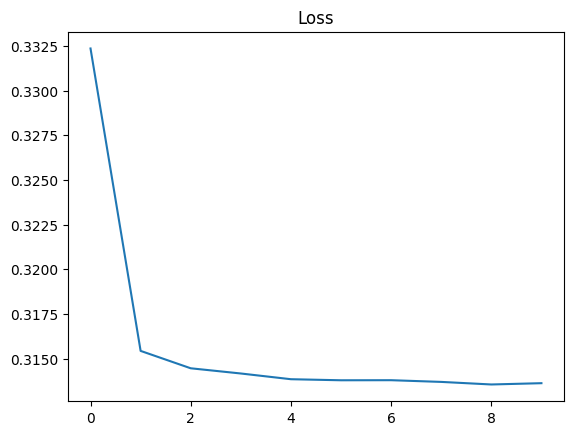

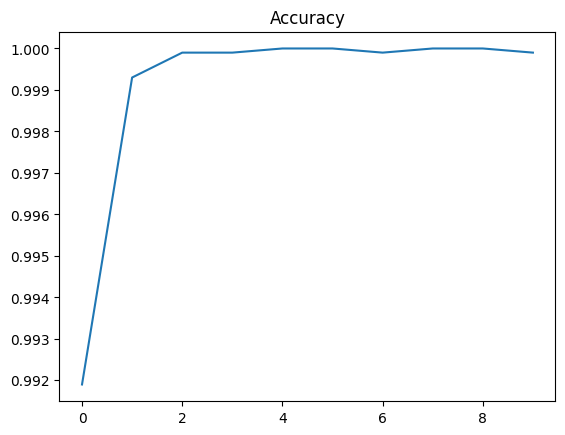

In [10]:
epochs = 10
loss_list = []
acc_list = []
for epoch in range(epochs):
    loss, acc = train(epoch, feature_extractor, optimizer, criterion)
    loss_list.append(loss)
    acc_list.append(acc)

plt.plot(loss_list)
plt.title('Loss')
plt.show()
plt.plot(acc_list)
plt.title('Accuracy')
plt.show()

In [11]:
print(f'Test accuracy: {test(feature_extractor):.4f}')

Test accuracy: 0.9790


In [19]:
class MixedLoss(nn.Module):
    def __init__(self, alpha=0.5, margin=1.0):
        super().__init__()
        self.alpha = alpha
        self.margin = margin
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.triplet_loss = TripletLoss(margin=self.margin)
        
    def forward(self, prediction, target, anchor_emb, positive_emb, negative_emb):
        cross_entropy_loss = self.cross_entropy_loss(prediction, target)
        triplet_loss = self.triplet_loss(anchor_emb, positive_emb, negative_emb)
        loss = self.alpha * cross_entropy_loss + (1 - self.alpha) * triplet_loss
        return loss

class MixedDataset(TripletDataset):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        anchor_img = img
        positive_idx = np.random.choice(self.class_idx[target])
        positive_img = self.data[positive_idx]
        negative_idx = np.random.choice(self.class_idx[1 - target])
        negative_img = self.data[negative_idx]
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        return anchor_img, positive_img, negative_img, target

class MixedNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.feature_extractor.fc = nn.Identity()
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        features = self.feature_extractor(x)
        x = self.fc(features)
        return x, features

In [23]:
model = MixedNet(2)
model = model.to(device)
criterion = MixedLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

mixed_dataset = MixedDataset(root='./data', train=True, transform=transform, download=True)
mixed_loader = DataLoader(mixed_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [26]:
def train_mixed(epoch):
    y_true = []
    y_pred = []
    loss_list = []
    model.train()
    pbar = tqdm(mixed_loader)
    for batch_idx, (anchor, positive, negative, target) in enumerate(pbar):
        y_true += target.tolist()
        anchor, positive, negative, target = anchor.to(device), positive.to(device), negative.to(device), target.long().to(device)
        optimizer.zero_grad()
        prediction, anchor_emb = model(anchor)
        y_pred += torch.argmax(prediction, dim=1).tolist()
        _, positive_emb = model(positive)
        _, negative_emb = model(negative)
        loss = criterion(prediction, target, anchor_emb, positive_emb, negative_emb)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        pbar.set_description(f'Epoch {epoch} | Loss: {np.mean(loss_list):.4f} | Acc: {accuracy_score(y_true, y_pred):.4f}')
    return np.mean(loss_list), accuracy_score(y_true, y_pred)

Epoch 0 | Loss: 0.5927 | Acc: 0.8811: 100%|██████████| 313/313 [00:35<00:00,  8.70it/s]
Epoch 1 | Loss: 0.2188 | Acc: 0.9518: 100%|██████████| 313/313 [00:36<00:00,  8.50it/s]
Epoch 2 | Loss: 0.1291 | Acc: 0.9723: 100%|██████████| 313/313 [00:40<00:00,  7.77it/s]
Epoch 3 | Loss: 0.0788 | Acc: 0.9837: 100%|██████████| 313/313 [00:41<00:00,  7.63it/s]
Epoch 4 | Loss: 0.0542 | Acc: 0.9885: 100%|██████████| 313/313 [00:39<00:00,  8.01it/s]
Epoch 5 | Loss: 0.0279 | Acc: 0.9946: 100%|██████████| 313/313 [00:37<00:00,  8.28it/s]
Epoch 6 | Loss: 0.0267 | Acc: 0.9950: 100%|██████████| 313/313 [00:39<00:00,  7.92it/s]
Epoch 7 | Loss: 0.0156 | Acc: 0.9968: 100%|██████████| 313/313 [00:39<00:00,  8.00it/s]
Epoch 8 | Loss: 0.0099 | Acc: 0.9977: 100%|██████████| 313/313 [00:37<00:00,  8.44it/s]
Epoch 9 | Loss: 0.0060 | Acc: 0.9987: 100%|██████████| 313/313 [00:36<00:00,  8.53it/s]


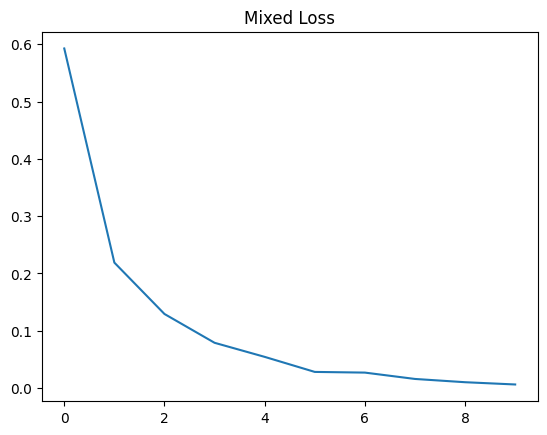

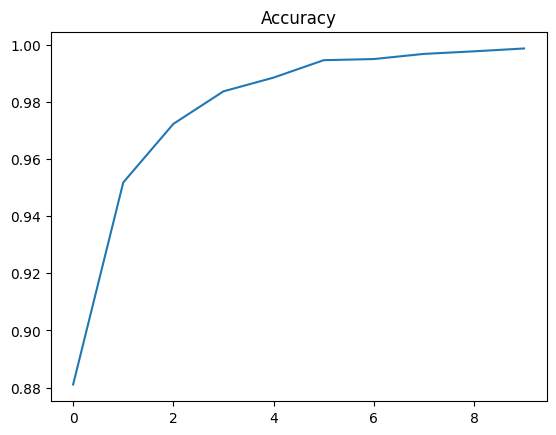

In [27]:
epochs = 10
loss_list = []
acc_list = []
for epoch in range(epochs):
    loss, acc = train_mixed(epoch)
    loss_list.append(loss)
    acc_list.append(acc)

plt.plot(loss_list)
plt.title('Mixed Loss')
plt.show()
plt.plot(acc_list)
plt.title('Accuracy')
plt.show()